In [65]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import random
import nltk
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
from IPython.display import display, HTML
import collections

# Setting width of the notebook to 85% of screen width
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

%matplotlib inline
nltk.download('wordnet',quiet=True)
lmtzr = WordNetLemmatizer()

In [66]:
def load(path, kind):
    pickle_path = '{}/master.pkl'.format(path)
    if os.path.exists(pickle_path):
        return pd.read_pickle(pickle_path, compression='gzip')
    
    df = pd.DataFrame(columns=['_document','_data','_class'])
    
    for root, dirname, files in os.walk('{}/{}/neg'.format(path,kind)):
        files = [os.path.join(root,fname) for fname in files]
        for file in files:
            with open(file, 'rt') as f:
                df = df.append({'_document':file,'_data':f.read(), '_class':'neg'}, ignore_index=True)

        for root, dirname, files in os.walk('{}/{}/pos'.format(path,kind)):
            files = [os.path.join(root,fname) for fname in files]
            for file in files:
                with open(file, 'rt') as f:
                    df = df.append({'_document': file,'_data':f.read(), '_class':'pos'}, ignore_index=True)
    df.to_pickle(pickle_path, compression='gzip')
    return df

In [67]:
df = load('data/aclImdb','train')
df = df.sample(frac=1.0)

In [68]:
def split(df, sl):
    sl = int(df.shape[0]*sl)
    return (df[:sl].copy(), df[sl:].copy())

In [69]:
train_df, dev_df = split(df, 0.8)

In [70]:
def remove_punctuation(document):
    document = re.sub('[-:;\'\"()?!]', ' ', document.lower())
    document = re.sub('</*\s*\w+\s*/*>', '', document)
    document = re.sub('\W+',' ',document)
    document = re.sub('\.+',' ',document)
    document = re.sub('\d+','',document)
    document = re.sub('\s+',' ', document)
    return document.split(' ')

In [71]:
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def remove_stopwords(document):
    return list(filter(lambda word: word not in stopwords, document))
    

In [72]:
def remove_rare_words(document):
    unq = set(document)
    n=random.randint(3,4)
    return list(filter(lambda word: document.count(word)>5, unq))

In [73]:
def prepare_vocab():
    wc = []
    train_df['_data'].apply(lambda data: wc.extend(data.split(' ')))
    wc = dict(collections.Counter(wc))
    print('Total distinct words before removing rare words: {}'.format(len(wc.keys())))
    wc = [ k for k,v in wc.items() if v>5 ]
    print('Total distinct words after removing rare words: {}'.format(len(wc)))
    return wc

In [74]:
def eliminate_rare_words(document):
    return set(document).intersection(wc)

In [75]:
def lemmatize(document):
    return [lmtzr.lemmatize(word) for word in document]

In [76]:
def clean(document):
    document = remove_punctuation(document)
    document = remove_stopwords(document)
    document = eliminate_rare_words(document)
    document = lemmatize(document)
    if not document:
        return np.NAN
    return document

In [77]:
wc = prepare_vocab()

Total distinct words before removing rare words: 245228
Total distinct words after removing rare words: 36677


In [78]:
train_df['_data'] = train_df['_data'].apply(clean)
print(train_df.shape)
train_df.head(10)

(20000, 3)


,_document,_data,_class
15058,data/aclImdb/train/pos/11741_10.txt,"[adult, widely, life, opportunity, right, appr...",pos
4951,data/aclImdb/train/neg/7515_1.txt,"[mean, failed, suck, scene, bad, involved, att...",neg
19851,data/aclImdb/train/pos/10465_8.txt,"[good, easy, involve, viewer, fast, way, intri...",pos
22622,data/aclImdb/train/pos/1309_10.txt,"[enjoyed, made, watching, interesting, great, ...",pos
21638,data/aclImdb/train/pos/1092_10.txt,"[realize, miserable, come, two, always, play, ...",pos
14148,data/aclImdb/train/pos/2364_10.txt,"[must, tale, perfect, enjoyed, fault, hope, su...",pos
13270,data/aclImdb/train/pos/8270_10.txt,"[emotion, cliche, something, stick, re, scene,...",pos
18594,data/aclImdb/train/pos/11823_9.txt,"[form, life, moment, major, enjoyed, re, sure,...",pos
19679,data/aclImdb/train/pos/7051_10.txt,"[good, obvious, incredible, message, accent, r...",pos
1603,data/aclImdb/train/neg/2409_1.txt,"[actually, house, jar, scene, place, working, ...",neg


In [79]:
dev_df['_data'] = dev_df['_data'].apply(clean)
print(dev_df.shape)
dev_df.head(10)

(5000, 3)


,_document,_data,_class
24642,data/aclImdb/train/pos/5493_10.txt,"[always, medium, re, repeated, innocent, rare,...",pos
13577,data/aclImdb/train/pos/8502_9.txt,"[creating, moment, come, two, low, interesting...",pos
22817,data/aclImdb/train/pos/6176_9.txt,"[dollar, trek, dvd, seek, perfect, visitor, ve...",pos
9001,data/aclImdb/train/neg/1964_1.txt,"[said, come, two, darkness, re, star, unfortun...",neg
6462,data/aclImdb/train/neg/5502_3.txt,"[good, individual, disappointment, always, ins...",neg
20871,data/aclImdb/train/pos/87_10.txt,"[without, buy, excited, orange, something, tre...",pos
5244,data/aclImdb/train/neg/11008_1.txt,"[said, good, actually, bin, dvd, stupid, right...",neg
19476,data/aclImdb/train/pos/3602_7.txt,"[tough, average, instead, sure, thing, problem...",pos
14843,data/aclImdb/train/pos/6347_9.txt,"[adult, detractor, attitude, two, always, re, ...",pos
10532,data/aclImdb/train/neg/8397_3.txt,"[finally, action, ruined, jerry, instead, re, ...",neg


In [80]:
pos = train_df[train_df['_class']=='pos']['_data'].apply(lambda x: ' '.join(x)).values
neg = train_df[train_df['_class']=='neg']['_data'].apply(lambda x: ' '.join(x)).values

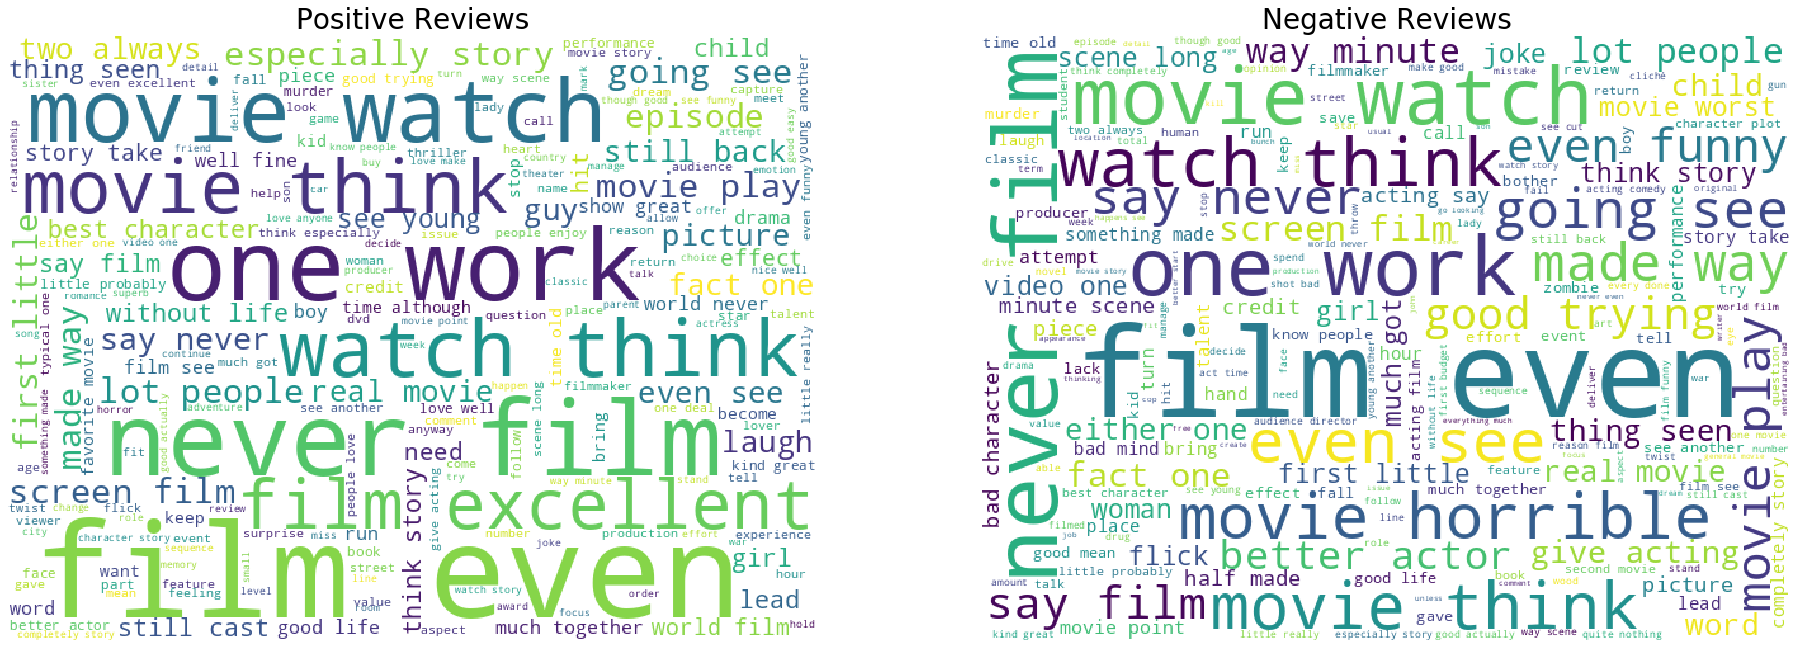

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[32,18])
cloud1 = WordCloud(background_color='white',width=640,height=480).generate(' '.join(pos))
cloud2 = WordCloud(background_color='white', width=640,height=480).generate(' '.join(neg))

ax1.imshow(cloud1)
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=28)

ax2.imshow(cloud2)
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=28)
plt.show()

# Determine Accuracy over dev set

In [82]:
num_docs = {'pos': train_df[train_df['_class']=='pos'].shape[0]
            ,'neg': train_df[train_df['_class']=='neg'].shape[0]}
P_sent = {}
P_word = {}
Pcond_word = {'pos':{}, 'neg':{}}

In [83]:
P_sent['pos'] = num_docs['pos']/train_df.shape[0]
P_sent['neg'] = num_docs['neg']/train_df.shape[0]
def get_conditional_prob(word, corpus, sentiment):
    if word not in P_word:
        P_word[word] = corpus[corpus['_data'].map(set([word]).issubset)].shape[0] \
        /corpus.shape[0]
        
    if word not in Pcond_word[sentiment]:
        Pcond_word[sentiment][word] = corpus[(corpus['_class']==sentiment) \
                  & (corpus['_data'].map(set([word]).issubset))].shape[0] / num_docs[sentiment]    
    try:
        return (Pcond_word[sentiment][word]*P_sent[sentiment])/P_word[word]
    except ZeroDivisionError:
        return 0.0
    

In [84]:
def calculate_sentiment_probability(document, corpus, sentiment):
    p = 1
    for word in document:
        p = p*get_conditional_prob(word, corpus, sentiment)
    return p

In [85]:
def predict_sentiment(row):
    if row['_pos']== 0.0 and row['_neg'] == 0.0:
        r = {'pos':'neg','neg':'pos'}
        return r[row['_class']]
    else:
        if row['_pos'] > row['_neg']:
            return 'pos'
        else:
            return 'neg'

In [86]:
# dev_df['_pos'] = dev_df['_data'].apply(lambda document: calculate_sentiment_probability(document, train_df, 'pos'))
# dev_df['_neg'] = dev_df['_data'].apply(lambda document: calculate_sentiment_probability(document, train_df, 'neg'))
# dev_df['_predicted_class'] = dev_df.apply(lambda row: predict_sentiment(row), axis=1)

In [87]:
# dev_df.head(20)

In [88]:
# acc = dev_df[dev_df['_class']==dev_df['_predicted_class']].shape[0]/dev_df.shape[0]
# print(acc)

In [112]:
pos_docs = train_df[train_df['_class']=='pos'] 
neg_docs = train_df[train_df['_class']=='neg'] 
def get_prob(word):
    s = set([word])
    docs_with_word = train_df[train_df['_data'].map(s.issubset)]
    pos_docs_with_word =  pos_docs[pos_docs['_data'].map(s.issubset)].shape[0]
    neg_docs_with_word =  neg_docs[neg_docs['_data'].map(s.issubset)].shape[0]
    pw = docs_with_word.shape[0]/train_df.shape[0]
    try:
        pw_pos = pos_docs_with_word*num_docs['pos']/pw
    except ZeroDivisionError:
        pw_pos = 0.0
    try:
        pw_neg = neg_docs_with_word*num_docs['neg']/pw
    except ZeroDivisionError:
        pw_neg = 0.0
        
    return {'pw': pw, 'pw_pos': pw_pos, 'pw_neg':pw_neg}

In [113]:
vocab = [(w,get_prob(w)) for w in wc[:5]]
vocab

[('This', {'pw': 0.0, 'pw_pos': 0.0, 'pw_neg': 0.0}),
 ('tender',
  {'pw': 0.0038, 'pw_pos': 162717368.42105263, 'pw_neg': 36941578.94736842}),
 ('beautifully',
  {'pw': 0.01655, 'pw_pos': 169932688.82175228, 'pw_neg': 29687190.332326286}),
 ('crafted',
  {'pw': 0.0067, 'pw_pos': 153316268.6567164, 'pw_neg': 46393582.08955224}),
 ('production',
  {'pw': 0.0639, 'pw_pos': 88961032.86384977, 'pw_neg': 111097276.99530517})]